In [244]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['image.origin'] = 'lower'

In [245]:
# I started this from 
#   The Fraction of Broken Waves in Natural Surf Zones [Stringari & Power] https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JC015213
#   They reference:
#       Transformation of wave height distribution [Thornton & Guza] (1983) https://agupubs.onlinelibrary.wiley.com/doi/10.1029/JC088iC10p05925
#       Energy Loss and Set-Up Due to Breaking of Random Waves [Battjes & Janssen] (1978) https://ascelibrary.org/doi/10.1061/9780872621909.034

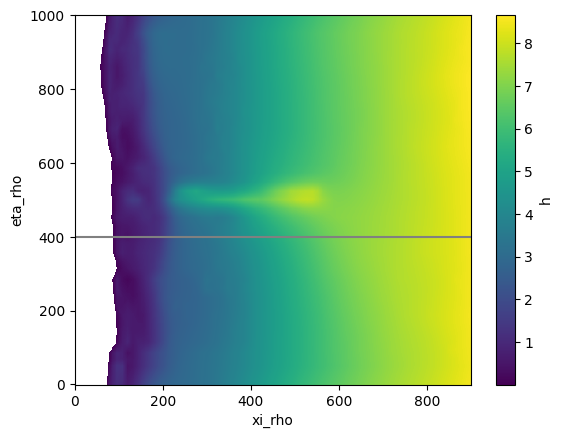

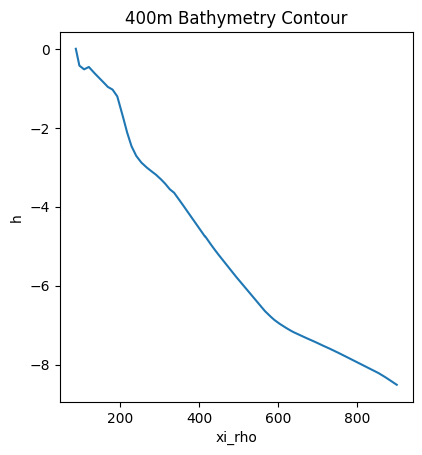

In [246]:
# Take a bathy profile, in this case mission 32. We'll consider a cross shore transect at 400m alongshore in this reference frame
# NOTE: Figure out what this is in FRF coordinates?
cross = 400
bathy = xr.load_dataset('model/code/bathy/ocean_dunex_grd32.nc')
bathy['h'].values[bathy.h.values <= 0] = np.nan
bathy.h.plot()
plt.axhline(cross, c='gray')
ny, nx = bathy.h.shape

# Here's that contour
plt.figure()
D = (-bathy.h.sel(eta_rho=cross))
D.plot()
plt.title(f'{cross}m Bathymetry Contour')
plt.gca().set_aspect(100)

In [247]:
# Some metadata from this mission showing forcing from the 8m array
missions = pd.read_csv('data/mission_df.csv')
mission = missions[missions['mission number']==32]
mission

,Unnamed: 0,time,mission number,Hs [m],Tm [s],Mean Dir [deg],cross shore gamma location [m],break depth,freq [hz],energy density [m^2\hz],direction bins [deg],directional energy density [m^2/hz/deg],wind speed [m/s],wind direction [deg],water level [m]
39,39,2021-10-13 17:25:29.998680,32,1.091753,6.456496,59.175695,263.470935,3.119293,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.01459356204863603, 0.013802312733134417, 0....","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[4.0894119592849165e-05, 4.2284758819732815e-...",6.483833,4.238652,0.781


In [248]:
H_s = mission['Hs [m]'].item()
H_rms = H_s / 2 * np.sqrt(2)

# Rough estimate of the total number of waves during the measurement period
minutes_of_data = 17
N = (minutes_of_data * 60) / mission['Tm [s]'].item() 

# Maximum wave height following 
# The statistical distribution of the maxima of a random function  [Cartwright & Longuet-Higgins, 1956] https://doi.org/10.1098/rspa.1956.0173
H_max = (np.log(N)**0.5 + 0.2886 * np.log(N)**-0.5)*H_rms
H_max = H_max.item()

Text(0, 0.5, 'p(H)')

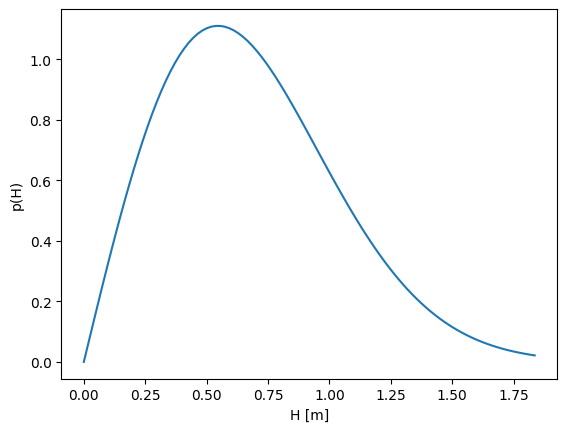

In [249]:
# Create a wave height distribution (Rayleigh PDF)
H = np.linspace(0, H_max, 100)
p = lambda H: 2*H / H_rms**2 * np.exp(-(H/H_rms)**2)
plt.plot(H, p(H))
plt.xlabel('H [m]')
plt.ylabel('p(H)')

# This next portion follows TG'89
$p_b(H) = W(H)p(H)$

$p(H) = \frac{2H}{H_{rms}^2}exp[-(\frac{H}{H_{rms}})^2]$

The simplest hypothesis, that break proportional to the height distribution is 

$W(H) = A_b = (\frac{H_{rms}{\gamma h}})^n$

The following modification more heavily weights large waves

$W(H) = (\frac{H_{rms}}{\gamma h})^n[1-exp(-(\frac{H}{\gamma h})^2)] \leq 1$

$Q_b = \int_0^{\infty} p_b(H) dH$

In [250]:
# This first section considers a constant p(H) from off shore

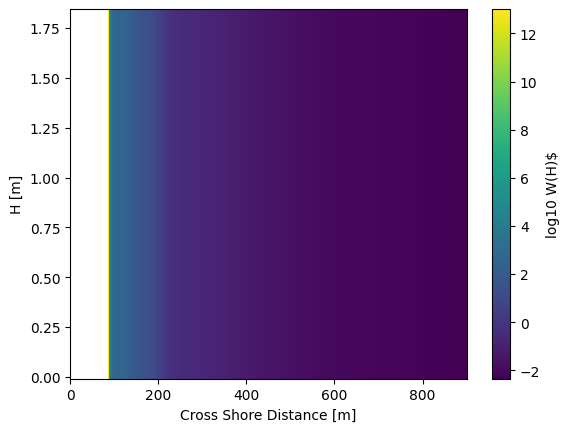

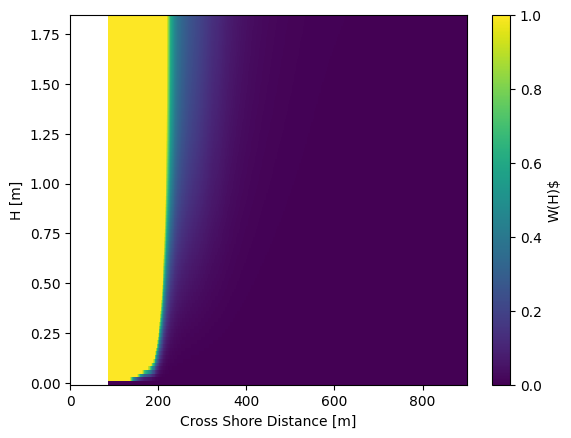

In [251]:
h = D.values

# Free parameters
n = 4
gamma = 0.35

# Weighting function

# Simple proportional to p(H)
w = lambda H: np.ones_like(H) * (H_rms/gamma/h)**n

H_grid = (np.ones(nx)[:, np.newaxis] * H[np.newaxis, :]).T

plt.figure()
plt.pcolormesh(
    np.arange(nx), H,
    np.log10(w(H_grid))
)
plt.xlabel('Cross Shore Distance [m]')
plt.ylabel('H [m]')
plt.colorbar(label='log10 W(H)$')
# plt.colorbar(label='$p_b(H) = W(H)p(H)$')

# Biased towards large waves
w = lambda H: np.minimum((H_rms/gamma/h)**n * (1 - np.exp(-(H/gamma/h)**2)), 1)


plt.figure()
plt.pcolormesh(
    np.arange(nx), H,
    (w(H_grid))
)
plt.xlabel('Cross Shore Distance [m]')
plt.ylabel('H [m]')
plt.colorbar(label='W(H)$')

(0.0, 4.0)

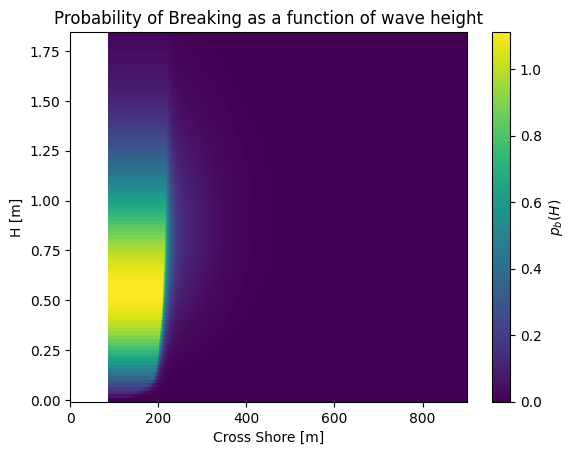

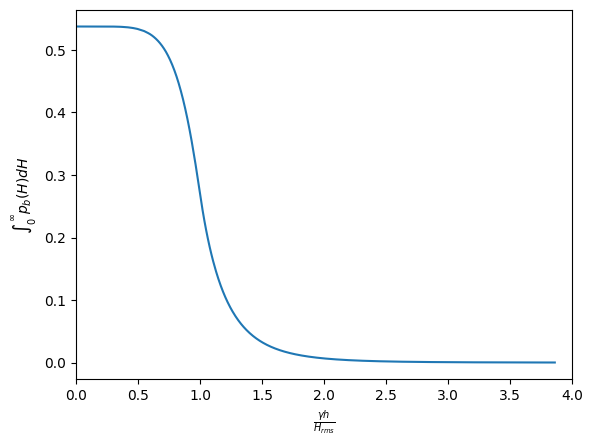

In [252]:
pb =  p(H)[:, np.newaxis] * w((np.ones(901)[:, np.newaxis] * H[np.newaxis, :]).T)
plt.figure()
plt.title('Probability of Breaking as a function of wave height')
plt.pcolormesh(np.arange(nx), H, pb)
plt.colorbar(label='$p_b(H)$')
plt.xlabel('Cross Shore [m]')
plt.ylabel('H [m]')


# This follows Figure 11 from TG89. 
# NOTE: Should go to 1?
plt.figure()
plt.plot(
    gamma * -h/H_rms,
    np.mean(pb, axis=0)
)
plt.xlabel(r'$\frac{\gamma h}{H_{rms}}$')
plt.ylabel(r'$\int_0^\infty p_b(H) dH$')
plt.xlim((0, 4))

Text(0, 0.5, 'TG`89 Qb')

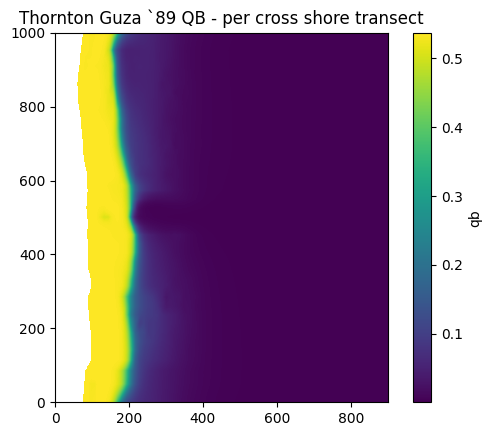

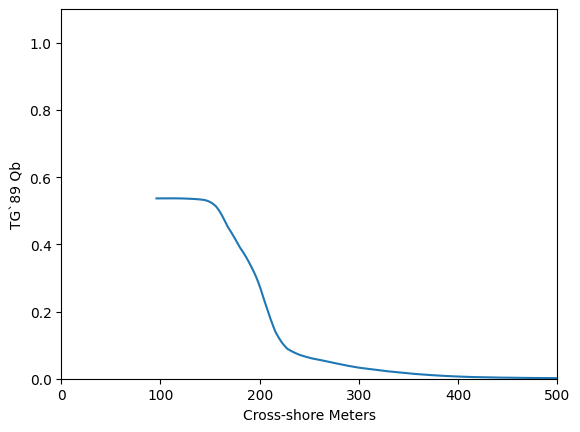

In [253]:
qb = np.zeros_like(bathy.h.values)
for i in range(1001):
    D = (-bathy.h.isel(eta_rho=i))
    h = D.values
    w = lambda H: np.minimum((H_rms/gamma/h)**n * (1 - np.exp(-(H/gamma/h)**2)), 1)
    p = lambda H: 2*H / H_rms**2 * np.exp(-(H/H_rms)**2)
    pb = p(H)[:, np.newaxis] * w((np.ones(901)[:, np.newaxis] * H[np.newaxis, :]).T)
    qb[i, :] = np.mean(pb, axis=0)
    # qb[i, :] /= 100# np.sum(qb[i, :])
plt.imshow(qb)
plt.colorbar(label='qb')

plt.ylim((0, 1000))
plt.title('Thornton Guza `89 QB - per cross shore transect')

plt.figure()
plt.plot(qb.mean(axis=0))
plt.xlim(0, 500)
plt.ylim(0, 1.1)
plt.xlabel('Cross-shore Meters')
plt.ylabel('TG`89 Qb')

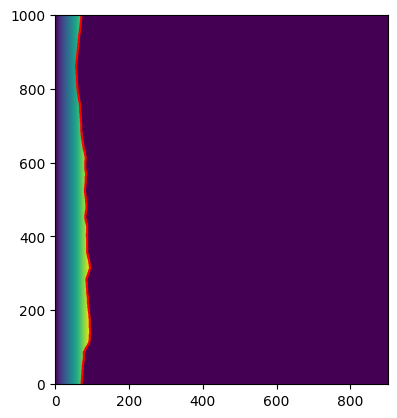

In [254]:
plt.imshow(np.isnan(bathy.h) * np.arange(0, 901))
shoreline = np.argmax(
    np.isnan(bathy.h.values) * np.arange(0, 901),
    axis=1)
plt.plot(shoreline, np.arange(1001), c='r')

Text(0, 0.5, 'Mean Qb')

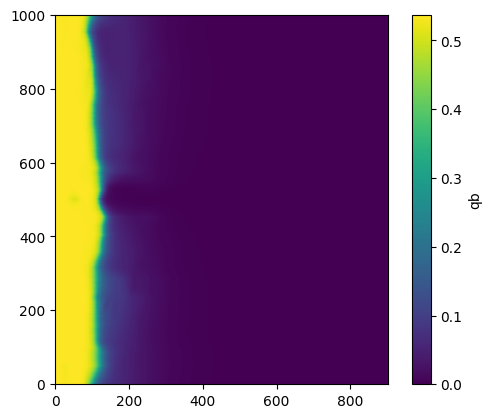

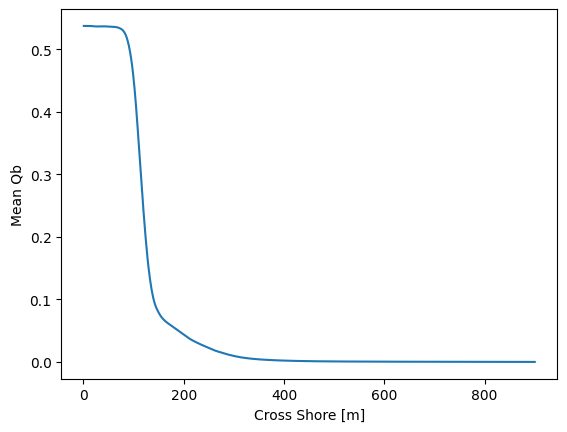

In [255]:
aligned_qb = np.zeros_like(qb)
for i, start in enumerate(shoreline):
    aligned_qb[i, 0:aligned_qb.shape[1] - start] = qb[i, start:]
plt.imshow(aligned_qb)
plt.colorbar(label='qb')
plt.figure()
plt.plot(aligned_qb.mean(0))
plt.xlabel('Cross Shore [m]')
plt.ylabel('Mean Qb')

In [256]:
# The next section considers a changing p(H)

In [257]:
w = lambda H: np.minimum((H_rms/gamma/h)**n * (1 - np.exp(-(H/gamma/h)**2)), 1)
w(H)

ValueError: operands could not be broadcast together with shapes (100,) (901,) 

In [266]:
gamma = 0.6
i = 0
pH = p(H)
colors = plt.cm.jet(np.arange(900))    
for j in reversed(range(900)):
    h = (-bathy.h.isel(eta_rho=i)).values[j]


fig, axs = plt.subplots(4, 1, figsize=(10,7))
for j in reversed(range(900)):
    h = (-bathy.h.isel(eta_rho=i)).values[j]
    w = lambda H: np.minimum((H_rms/gamma/h)**n * (1 - np.exp(-(H/gamma/h)**2)), 1)
    pb = pH * w(H)
    pH -= pb
    
    axs[0].scatter(j, h, c=[plt.cm.jet(j/900)])
    if j%10 == 0:
        axs[1].plot(H, pH, color=plt.cm.jet(j/900))
        axs[2].plot(H, pb, color=plt.cm.jet(j/900))
        axs[3].scatter(j, np.sum(pb), color=[plt.cm.jet(j/900)])


axs[0].set_xlabel('Cross shore [m]')
axs[0].set_ylabel('h')    

axs[1].set_xlabel('H [m]')
axs[1].set_ylabel('p(H)')

axs[2].set_xlabel('H [m]')
axs[2].set_ylabel('$p_b(H)$')

axs[3].set_xlabel('Cross shore [m]')
axs[3].set_ylabel('$Qb$')
plt.tight_layout()
fig.suptitle(
'''Thorton Guza 89 Analytical QB\n
$p_b(H) = W(H)p(H)$\n
$p(H) = \frac{2H}{H_{rms}^2}exp[-(\frac{H}{H_{rms}})^2]$\n
$W(H) = (\frac{H_{rms}}{\gamma h})^n[1-exp(-(\frac{H}{\gamma h})^2)] \leq 1$\n
$Q_b = \int_0^{\infty} p_b(H) dH$''')


<>:36: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\g'
/var/folders/xv/4vxt441n3tz_yllzvqvzmsgw0000gr/T/ipykernel_22127/3191877209.py:36: SyntaxWarning: invalid escape sequence '\g'
  '''


Text(0.5, 0.98, '\nThorton Guza 89 Analytical QB\n\n\n$p_b(H) = W(H)p(H)$\n\n\n$p(H) = \x0crac{2H}{H_{rms}^2}exp[-(\x0crac{H}{H_{rms}})^2]$\n\n\n$W(H) = (\x0crac{H_{rms}}{\\gamma h})^n[1-exp(-(\x0crac{H}{\\gamma h})^2)] \\leq 1$\n\n\n$Q_b = \\int_0^{\\infty} p_b(H) dH$\n')

Error in callback <function _draw_all_if_interactive at 0x15f19e340> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
$p(H) = rac{2H}{H_{rms}^2}exp[-(rac{H}{H_{rms}})^2]$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$p(H) = rac{2H}{H_{rms}^2}exp[-(rac{H}{H_{rms}})^2]$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1000x700 with 4 Axes>

In [259]:
# # Gross non-parallelized version of this 
# # TODO: the outer loop can be vectorized which would speed this up immensely
# gamma = 0.6
# qb = np.zeros((1001, 901))
# pH_grid = np.ones(1001)[:, np.newaxis] * p(H)[np.newaxis, :]

# for j in reversed(range(900)):
#     h = (-bathy.h.values[:, j])
      
#     H_grid = np.ones(1001)[:, np.newaxis] * H[np.newaxis, :]
    
#     pb = pH_grid.T * w(H_grid.T)
#     pH_grid -= pb.T
    
#     qb[:, j] = np.sum(pb)
# plt.imshow(qb)

In [263]:
# Gross non-parallelized version of this 
# TODO: the outer loop can be vectorized which would speed this up immensely
gamma = 0.4
qb = np.zeros((1001, 901))
for i in range(1000):
    pH = p(H)
    wH = w(H)
    for j in reversed(range(900)):
        h = (-bathy.h.isel(eta_rho=i)).values[j]

    for j in reversed(range(900)):
        h = (-bathy.h.isel(eta_rho=i)).values[j]
        w = lambda H: np.minimum((H_rms/gamma/h)**n * (1 - np.exp(-(H/gamma/h)**2)), 1)
        pb = pH * w(H)
        pH -= pb
        
        qb[i, j] = np.maximum(np.sum(pb), 1)


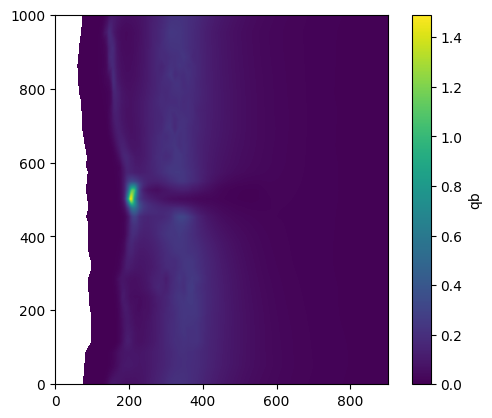

In [261]:
plt.imshow(qb)
plt.colorbar(label='qb')

In [178]:
# Initialize qb
qb = np.zeros((1001, 901))

# Calculate pH (assuming p is a function that works on 1D arrays)
pH = p(H)  # Shape: (100,)

# Vectorize the h calculation
h = -bathy.h.values[:1000, :900][:, ::-1]  # Shape: (1000, 900)

# Define the vectorized w function
def w_vec(H, h):
    H_3d = H[:, np.newaxis, np.newaxis]  # Shape: (100, 1, 1)
    h_3d = h[np.newaxis, :, :]  # Shape: (1, 1000, 900)
    return np.minimum((H_rms/gamma/h_3d)**n * (1 - np.exp(-(H_3d/gamma/h_3d)**2)), 1)

# Vectorize the main calculation
pb = pH[:, np.newaxis, np.newaxis] * w_vec(H, h)  # Shape: (100, 1000, 900)

# Sum over the H dimension
qb[:1000, :900] = np.flip(np.sum(pb, axis=0), 1)



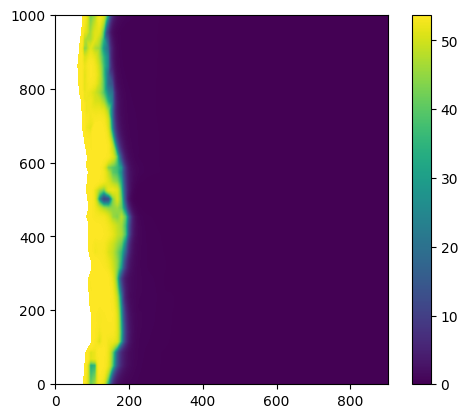

In [180]:
plt.imshow(qb)
plt.colorbar()